   # TP53: Effects of Mutation on Target Proteins
   <b>p53 target genes</b>

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [2]:
import CPTAC

Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### List of gene targets of activated p53 (according this publication): http://content.ebscohost.com/ContentServer.asp?EbscoContent=dGJyMMvl7ESeqLQ4zOX0OLCmr1Cep7JSsKu4S66WxWXS&ContentCustomer=dGJyMPGuskyurK5IuePfgeyx43zx1%2BqE&T=P&P=AN&S=R&D=aph&K=31739073

<b>Line 1: Apoptosis
   Line 2: Cell-cycle arrest
   Line 3: DNA repair 
   Lines 4-6: Cluster sites</b>

In [29]:
gene = 'TP53'
protList = ['FAS', 'BAX', 'BBC3', 'BIRC5', 
            'CDKN1A', 'SFN', 'TP53I3', 'CDC25C',
           'DDB2', 'DDIT4', 'GADD45a', 'TRIM22',
           'BTG2', 'GML', 'HRAS', 'IGFBP3', 'MDM2',
           'PCNA', 'SH2D1A', 'TP73', 'TRPM2', 'TYRP1',
           'VDR', 'HBV']

### t-test for proteome abundance of these proteins when TP53 is mutated
<b>Note: We are only interested in looking at proteins whose abundance is significantly affected by TP53 mutation, and we must do a Bonferroni correction on our p-value</b>

In [30]:
pcutoff = 0.05 / len(protList)

In [31]:
significantResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.merge_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            significantResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

Test for DDB2: 
Ttest_indResult(statistic=-4.293458420698654, pvalue=3.428366421713149e-05)
Test for PCNA: 
Ttest_indResult(statistic=4.265943432846142, pvalue=3.820082304054725e-05)


### List of significantly affected proteins

In [24]:
print(significantResults)

['DDB2']


### t-test for effects of frame shift and nonsense mutations of TP53 on protein levels of the above 5 proteins

In [25]:
significantResults.append(gene)
for protein in significantResults: 
    if protein in proteomics.columns:
        cross = CPTAC.merge_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[(cross["Mutation"] == "Frame_Shift_Del") | 
                            (cross["Mutation"] == "Frame_Shift_Ins") |
                            (cross["Mutation"] == 'Nonsense_Mutation')]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print("Test for " + protein + ": ")
        print(ttest) 

Test for DDB2: 
Ttest_indResult(statistic=-1.6080627480409195, pvalue=0.11042767954025501)
Test for TP53: 
Ttest_indResult(statistic=-0.8747451134751877, pvalue=0.38374777137438243)


### Build the dataframe for plotting

In [29]:
plotdf = CPTAC.merge_mutations(proteomics, gene)[['Mutation', gene]]

for protein in significantResults:
    if(protein is not 'TP53'):
        proteindf = CPTAC.merge_mutations(proteomics, protein, gene)[[protein]]
        plotdf = plotdf.join(proteindf)

In [30]:
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'
                                     }})

In [31]:
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Proteomics')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0)

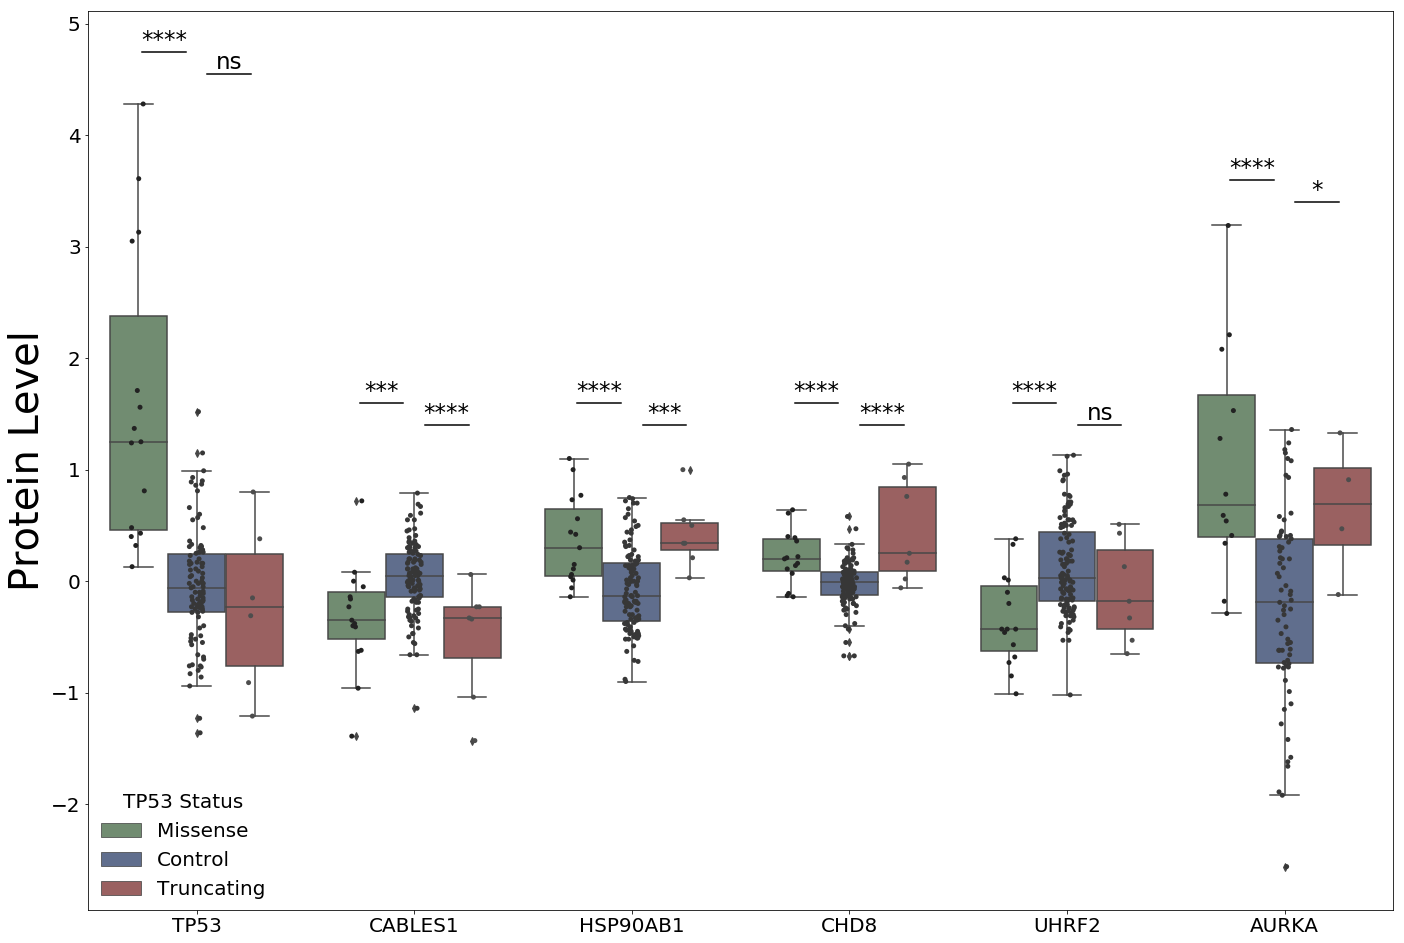

In [32]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='40')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Missense', 'Control', 'Truncating'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.15, 0.15, 0, 0))

#Add significance indicator: TP53/Missense
x1, x2 = -0.25, -0.05
y, h, col = 4.45, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: TP53/Truncation
x1, x2 = 0.05, 0.25
y, h, col = 4.25, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: CABLES1/Missense
x1, x2 = 0.75, 0.95
y, h, col = 1.3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: CABLES1/Truncation
x1, x2 = 1.05, 1.25
y, h, col = 0.8 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: HSP90AB1/Missense
x1, x2 = 1.75, 1.95
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: HSP90AB1/Truncation
x1, x2 = 2.05, 2.25
y, h, col = 0.8 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: CHD8/Missense
x1, x2 = 2.75, 2.95
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: CHD8/Truncation
x1, x2 = 3.05, 3.25
y, h, col = 0.8 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: UHRF2/Missense
x1, x2 = 3.75, 3.95
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: UHRF2/Truncation
x1, x2 = 4.05, 4.25
y, h, col = 0.8 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: AURKA/Missense
x1, x2 = 4.75, 4.95
y, h, col = 3 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='23')

#Add significance indicator: AURKA/Truncation
x1, x2 = 5.05, 5.25
y, h, col = 2.8 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='23')

fig = boxplt.get_figure()
fig.savefig('p53_trans.png', dpi=300)
plt.show()

## Phosphoproteome abundance of interacting proteins

### This is the same list as before, with some of the end numbers of the proteins removed; less specificity in protein names captures more potentially significant results in the phosphoproteomic data

In [37]:
phosProtList = ['FAS', 'BAX', 'BBC', 'BIRC', 
            'CDKN1A', 'SFN', 'TP53I3', 'CDC25C',
           'DDB', 'DDIT', 'GADD45a', 'TRIM',
           'BTG', 'GML', 'HRAS', 'IGFBP', 'MDM',
           'PCNA', 'SH2D', 'TP73', 'TRPM', 'TYRP',
           'VDR', 'HBV']

In [38]:
sites = phos.columns;
significantPhosResults = [];
totalSites = 0

for protein in phosProtList:
    matchesdf = phos.filter(regex=protein)
    totalSites += len(matchesdf.columns)

pcutoff = 0.05 / totalSites   

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.merge_mutations(phos, protein, gene)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.merge_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] == 'Missense_Mutation'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if(ttest[1] <= pcutoff):
                    significantPhosResults.append(site)
                    print("Test for " + site + ": ")
                    print(ttest) 

Test for BIRC6-S2955: 
Ttest_indResult(statistic=4.0908908330111435, pvalue=0.00010278513697845165)
Test for DDB2-S26: 
Ttest_indResult(statistic=-4.226924669833216, pvalue=4.449969744724638e-05)


### List of significantly affected phosphorylation sites

In [39]:
print(significantPhosResults)

['BIRC6-S2955', 'DDB2-S26']
